In [447]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 17

import seaborn as sns
import re
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)

In [448]:
## DATA
# Import/Load
data = pd.read_csv('../app/data/total.csv')

    The following table is a view of the raw data from the scrape. I'll build the target by reducing the pay column to floating point values; this will require text cleaning which will also be conducted for the rest of the table. Location will be split into new columns for City and State while and because Indeed's search results show dates relative to the date the query was made I'll need to use PostDate and ExtractDate build a DatePosted column. It is important to note that JobUrl and date-related columns will not be converted into features for the logistic regression, instead they will be reattached to the data at the end in order to provide additional information and insights through the EC2 application. The only rows that'l  be using for modelling are JobTitle, Company, Summary, Requirements, and Description.

In [449]:
#  Examine
data.head(5)

,company,description,estimated_salary,extractDate,job_type_items,location,postDate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jType,salfromsection,summary,title,url
0,Online Technical Services,"Job descriptionData Scientist, MarketingSAN DI...",NaN,2022-04-13,['Full-time'],Remote,PostedJust posted,3.7,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Master's (Preferred)Python: 1 year (Preferred)...,NaN,"$145,000 - $150,000 a year","$145,000 - $150,000 a year - Full-time","$145,000 - $150,000 a year",Identify relevant data sources and data sets t...,Data Scientist - Marketing,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
1,West CAP,HUMAN was founded in 2012 in a Brooklyn sci-fi...,Estimated $114K – $144K a year,2022-04-13,NaN,"Remote in New York, NY+2 locations",PostedJust posted,3.5,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$114K to $14...",NaN,Full-time,NaN,You’ve worked as a data scientist solving larg...,"Data Scientist, BotGuard",https://www.indeed.com/rc/clk?jk=58cdde046f643...
2,Maya Ai inc.,Our Maya team is expanding and we are looking ...,NaN,2022-04-13,"['Full-time', 'Part-time']",Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Python: 1 year (Preferred)SQL: 1 year (Preferred),NaN,"$77,766 - $183,411 a year","$77,766 - $183,411 a year - Full-time, Part-time","$77,766 - $183,411 a year",Our Analyst will be dealing with data coming i...,Data Scientist,https://www.indeed.com/company/Maya-Ai-inc./jo...
3,"EMERGETECH, INC",Description:Job CategoryData ScienceAbout Emer...,Estimated $94.7K – $120K a year,2022-04-13,NaN,Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$94.7K to $1...",NaN,NaN,NaN,Design and create the data sources that ”citiz...,Data Scientist,https://www.indeed.com/rc/clk?jk=95fb128bb025f...
4,Recurrent,What's the opportunity?Recurrent is on a missi...,Estimated $119K – $151K a year,2022-04-13,NaN,"Remote in Seattle, WA",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$119K to $15...",NaN,NaN,NaN,Experienced - you have 2+ years of experience ...,Data Scientist,https://www.indeed.com/rc/clk?jk=e9ce610b72deb...


In [450]:
data[data.location == 'Remote'].head(5)

,company,description,estimated_salary,extractDate,job_type_items,location,postDate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jType,salfromsection,summary,title,url
0,Online Technical Services,"Job descriptionData Scientist, MarketingSAN DI...",NaN,2022-04-13,['Full-time'],Remote,PostedJust posted,3.7,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Master's (Preferred)Python: 1 year (Preferred)...,NaN,"$145,000 - $150,000 a year","$145,000 - $150,000 a year - Full-time","$145,000 - $150,000 a year",Identify relevant data sources and data sets t...,Data Scientist - Marketing,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
2,Maya Ai inc.,Our Maya team is expanding and we are looking ...,NaN,2022-04-13,"['Full-time', 'Part-time']",Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Python: 1 year (Preferred)SQL: 1 year (Preferred),NaN,"$77,766 - $183,411 a year","$77,766 - $183,411 a year - Full-time, Part-time","$77,766 - $183,411 a year",Our Analyst will be dealing with data coming i...,Data Scientist,https://www.indeed.com/company/Maya-Ai-inc./jo...
3,"EMERGETECH, INC",Description:Job CategoryData ScienceAbout Emer...,Estimated $94.7K – $120K a year,2022-04-13,NaN,Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$94.7K to $1...",NaN,NaN,NaN,Design and create the data sources that ”citiz...,Data Scientist,https://www.indeed.com/rc/clk?jk=95fb128bb025f...
6,TechTrueUP,Description: DATA SCIENTIST*** Fully remote***...,NaN,2022-04-13,"['Full-time', 'Contract']",Remote,PostedJust posted,3.8,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Bachelor's (Required)Python: 1 year (Required)...,NaN,$60 - $70 an hour,"$60 - $70 an hour - Full-time, Contract",$60 - $70 an hour,DSC is seeking a Data Scientist who would be f...,MCS Data Scientist,https://www.indeed.com/company/TechTrueUP/jobs...
9,Redfin,This position is a remote eligible position...,NaN,2022-04-13,['Full-time'],Remote,PostedJust posted,3.4,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,"$87,600 - $131,400 a year","$87,600 - $131,400 a year - Full-time","$87,600 - $131,400 a year","Experience in analytics of operations, specifi...",Senior Data Analyst - Tour Support (Remote Eli...,https://www.indeed.com/rc/clk?jk=25a64fbe8a600...


In [451]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570 entries, 0 to 569
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           570 non-null    object 
 1   description       570 non-null    object 
 2   estimated_salary  272 non-null    object 
 3   extractDate       570 non-null    object 
 4   job_type_items    152 non-null    object 
 5   location          570 non-null    object 
 6   postDate          570 non-null    object 
 7   rating            356 non-null    float64
 8   raw_desc_soup     570 non-null    object 
 9   requirements      107 non-null    object 
 10  sal_guide_items   286 non-null    object 
 11  salary            158 non-null    object 
 12  salary_and_jType  387 non-null    object 
 13  salfromsection    157 non-null    object 
 14  summary           570 non-null    object 
 15  title             570 non-null    object 
 16  url               570 non-null    object 
dt

In [452]:
# Missing Values?
missing_values = data.isnull().sum()
print(missing_values)

company               0
description           0
estimated_salary    298
extractDate           0
job_type_items      418
location              0
postDate              0
rating              214
raw_desc_soup         0
requirements        463
sal_guide_items     284
salary              412
salary_and_jType    183
salfromsection      413
summary               0
title                 0
url                   0
dtype: int64


In [453]:
data[data.isnull().any(axis=1)]
# every column has nulls!

,company,description,estimated_salary,extractDate,job_type_items,location,postDate,rating,raw_desc_soup,requirements,sal_guide_items,salary,salary_and_jType,salfromsection,summary,title,url
0,Online Technical Services,"Job descriptionData Scientist, MarketingSAN DI...",NaN,2022-04-13,['Full-time'],Remote,PostedJust posted,3.7,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Master's (Preferred)Python: 1 year (Preferred)...,NaN,"$145,000 - $150,000 a year","$145,000 - $150,000 a year - Full-time","$145,000 - $150,000 a year",Identify relevant data sources and data sets t...,Data Scientist - Marketing,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
1,West CAP,HUMAN was founded in 2012 in a Brooklyn sci-fi...,Estimated $114K – $144K a year,2022-04-13,NaN,"Remote in New York, NY+2 locations",PostedJust posted,3.5,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$114K to $14...",NaN,Full-time,NaN,You’ve worked as a data scientist solving larg...,"Data Scientist, BotGuard",https://www.indeed.com/rc/clk?jk=58cdde046f643...
2,Maya Ai inc.,Our Maya team is expanding and we are looking ...,NaN,2022-04-13,"['Full-time', 'Part-time']",Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",Python: 1 year (Preferred)SQL: 1 year (Preferred),NaN,"$77,766 - $183,411 a year","$77,766 - $183,411 a year - Full-time, Part-time","$77,766 - $183,411 a year",Our Analyst will be dealing with data coming i...,Data Scientist,https://www.indeed.com/company/Maya-Ai-inc./jo...
3,"EMERGETECH, INC",Description:Job CategoryData ScienceAbout Emer...,Estimated $94.7K – $120K a year,2022-04-13,NaN,Remote,PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$94.7K to $1...",NaN,NaN,NaN,Design and create the data sources that ”citiz...,Data Scientist,https://www.indeed.com/rc/clk?jk=95fb128bb025f...
4,Recurrent,What's the opportunity?Recurrent is on a missi...,Estimated $119K – $151K a year,2022-04-13,NaN,"Remote in Seattle, WA",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$119K to $15...",NaN,NaN,NaN,Experienced - you have 2+ years of experience ...,Data Scientist,https://www.indeed.com/rc/clk?jk=e9ce610b72deb...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,California FAIR Plan Association,Position SummaryThe statistical reporting anal...,Estimated $73K - $92.4K a year,2022-04-15,NaN,"Remote in Los Angeles, CA 90010",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,"['', 'Not provided by employer', ""$73K to $92....",NaN,Full-time,NaN,Ability to understand data information systems...,Statistical Reporting Analyst (Remote),https://www.indeed.com/company/California-FAIR...
566,Optum,Combine two of the fastest-growing fields on t...,NaN,2022-04-15,NaN,"Remote in Eden Prairie, MN 55346+1 location",PostedJust posted,3.4,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,NaN,Full-time,NaN,"Troubleshoots data integrity issues, analyzes ...",Senior Data Analyst - Telecommute,https://www.indeed.com/rc/clk?jk=b164952160a87...
567,Collins Aerospace,This position is for an established Machine Le...,NaN,2022-04-15,NaN,"Remote in Cedar Rapids, IA+1 location",PostedJust posted,3.6,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,NaN,Full-time,NaN,"Transforms analytics, models, and other protot...",Machine Learning Engineer (Remote),https://www.indeed.com/rc/clk?jk=ca3746ffdf53f...
568,Manifold AI,"As a machine learning engineer, a large portio...",Estimated $133K - $169K a year,2022-04-15,NaN,"Remote in Boston, MA",PostedJust posted,NaN,"<!DOCTYPE html>\n\n<html dir=""ltr"" lang=""en"">\...",NaN,NaN,NaN,NaN,NaN,"As a machine learning engineer, a large portio...",Machine Learning Engineer,https://www.indeed.com/rc/clk?jk=eb1780fbeea78...


In [454]:
#  Value Counts
data.nunique()

company              38
description          43
estimated_salary     36
extractDate           3
job_type_items        4
location             28
postDate              1
rating               11
raw_desc_soup       450
requirements          7
sal_guide_items      32
salary               11
salary_and_jType     12
salfromsection       11
summary              63
title                35
url                  86
dtype: int64

In [455]:
data.company.unique()

array(['Online Technical Services', 'West CAP', 'Maya Ai inc.',
       'EMERGETECH, INC', 'Recurrent', 'Fractal.ai', 'TechTrueUP', 'EAB',
       'Ford Motor Company', 'Redfin', 'SparkCognition', 'CoderPad, Inc.',
       'Humana', 'Amadeus', 'The American College of Radiology',
       'Insight Global', 'IBM', 'CyberCoders', 'Calculated Hire',
       'CompuGain', 'Liberty Mutual Insurance', 'Comcentric',
       'EDWARD JONES', 'Vital Connect, Inc.', 'Updater',
       'Cambium Assessment', 'Optum', 'Opal', 'Home Depot / THD',
       'SCRUFF', 'Manifold AI', 'California FAIR Plan Association',
       'MultiPlan Inc.', 'Aledade', 'UnitedHealth Group', 'Lumen', 'PwC',
       'Collins Aerospace'], dtype=object)

In [456]:
interesting = ['company','estimated_salary','job_type_items','location','rating','requirements','salary','sal_guide_items','salary_and_jType']
for i in interesting:
    print(data[i].unique())

['Online Technical Services' 'West CAP' 'Maya Ai inc.' 'EMERGETECH, INC'
 'Recurrent' 'Fractal.ai' 'TechTrueUP' 'EAB' 'Ford Motor Company' 'Redfin'
 'SparkCognition' 'CoderPad, Inc.' 'Humana' 'Amadeus'
 'The American College of Radiology' 'Insight Global' 'IBM' 'CyberCoders'
 'Calculated Hire' 'CompuGain' 'Liberty Mutual Insurance' 'Comcentric'
 'EDWARD JONES' 'Vital Connect, Inc.' 'Updater' 'Cambium Assessment'
 'Optum' 'Opal' 'Home Depot / THD' 'SCRUFF' 'Manifold AI'
 'California FAIR Plan Association' 'MultiPlan Inc.' 'Aledade'
 'UnitedHealth Group' 'Lumen' 'PwC' 'Collins Aerospace']
[nan 'Estimated $114K – $144K a year' 'Estimated $94.7K – $120K a year'
 'Estimated $119K – $151K a year' 'Estimated $137K – $174K a year'
 'Estimated $84.5K – $107K a year' 'Estimated $117K – $148K a year'
 'Estimated $132K – $167K a year' 'Estimated $130K – $165K a year'
 'Estimated $72.3K – $91.5K a year' 'Estimated $114K - $144K a year'
 'Estimated $94.7K - $120K a year' 'Estimated $119K - $151K a y

In [457]:
samples = []
for i in np.unique(data[data['company'].notnull()].company):
    samples.append(i)
print(len(samples))
samples[:]

38


['Aledade',
 'Amadeus',
 'Calculated Hire',
 'California FAIR Plan Association',
 'Cambium Assessment',
 'CoderPad, Inc.',
 'Collins Aerospace',
 'Comcentric',
 'CompuGain',
 'CyberCoders',
 'EAB',
 'EDWARD JONES',
 'EMERGETECH, INC',
 'Ford Motor Company',
 'Fractal.ai',
 'Home Depot / THD',
 'Humana',
 'IBM',
 'Insight Global',
 'Liberty Mutual Insurance',
 'Lumen',
 'Manifold AI',
 'Maya Ai inc.',
 'MultiPlan Inc.',
 'Online Technical Services',
 'Opal',
 'Optum',
 'PwC',
 'Recurrent',
 'Redfin',
 'SCRUFF',
 'SparkCognition',
 'TechTrueUP',
 'The American College of Radiology',
 'UnitedHealth Group',
 'Updater',
 'Vital Connect, Inc.',
 'West CAP']

In [458]:
null = sum(data.salary.isnull())
nnull = sum(data.salary.notnull())
print(data.isnull().sum())
print('')
print(f'The data contains {data.shape[0]} rows of individual job postings with values for {data.shape[1]} columns based on\n different sections of each post\'s web page.')
print('')
print(f'- Out of {len(data)} job postings {nnull} or {round(nnull/len(data)*100,2)}% include some sort of salary information,\n- The remaining {null} rowws, or {round(null/len(data)*100,2)}% are missing salary data.\n- Also, there are no null values in the rest of the table meaning we won\'t need\n  to lose any data by dropping rows. While the null values in the Pay column will\n  simply be dropped after we translate the not nulls into the target.')

company               0
description           0
estimated_salary    298
extractDate           0
job_type_items      418
location              0
postDate              0
rating              214
raw_desc_soup         0
requirements        463
sal_guide_items     284
salary              412
salary_and_jType    183
salfromsection      413
summary               0
title                 0
url                   0
dtype: int64

The data contains 570 rows of individual job postings with values for 17 columns based on
 different sections of each post's web page.

- Out of 570 job postings 158 or 27.72% include some sort of salary information,
- The remaining 412 rowws, or 72.28% are missing salary data.
- Also, there are no null values in the rest of the table meaning we won't need
  to lose any data by dropping rows. While the null values in the Pay column will
  simply be dropped after we translate the not nulls into the target.


In [459]:
print('Here we can observe the sort of values held in the Pay column. Aside from removing special characters and spaces I\'ll extract\n the remaing non-numeric chars into a new column that\'ll allow me to build the annual Salary column once the remaining\n numeric string are converted to floating point.')

samples = []
for i in np.unique(data[data['sal_guide_items'].notnull()].sal_guide_items):
    samples.append(i)
samples[:3]

Here we can observe the sort of values held in the Pay column. Aside from removing special characters and spaces I'll extract
 the remaing non-numeric chars into a new column that'll allow me to build the annual Salary column once the remaining
 numeric string are converted to floating point.


['[\'\', \'Not provided by employer\', "$112K - $142K a year is Indeed\'s estimated salary for this role in Remote."]',
 '[\'\', \'Not provided by employer\', "$112K to $141K per year is Indeed\'s estimated salary for data scientist in Pittsburgh, PA 15222."]',
 '[\'\', \'Not provided by employer\', "$112K to $142K per year is Indeed\'s estimated salary for lead data scientist in Remote."]']

In [460]:
## Preprocess Data
data = pd.read_csv('../app/data/total.csv')
#  drop_dupes
data = data.drop_duplicates()
data.columns = map(str.lower, data.columns)
data = data.rename({'title': 'job_title'}, axis=1)

In [461]:
data.extractdate.value_counts()

2022-04-13    330
2022-04-14    120
2022-04-15    120
Name: extractdate, dtype: int64

In [462]:
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

In [463]:
def sal_chars(data):
    cleaned = re.sub(r'[\n|,|+|$|[|$|\'|"]',r'',data)
    return cleaned

def sal_splitter(data):
    x = data.split(',')
    return x[2]



In [464]:
salary = data[data.salary.notnull()]
data[['salary',]] = salary['salary'].apply(sal_chars)

estimated_salary = data[data.estimated_salary.notnull()]
data['estimated_salary'] = estimated_salary['estimated_salary'].apply(sal_chars)

salfromsection = data[data.salfromsection.notnull()]
data[['salfromsection',]] = salfromsection['salfromsection'].apply(sal_chars)

salary_and_jtype = data[data.salfromsection.notnull()]
data[['salary_and_jtype',]] = salary_and_jtype['salary_and_jtype'].apply(sal_chars)




sal_guide_arr = data[data.sal_guide_items.notnull()]
data[['sal_guide_items']] = sal_guide_arr['sal_guide_items'].apply(sal_splitter)

sal_guide_arr = data[data.sal_guide_items.notnull()]
data[['sal_guide_items']] = sal_guide_arr['sal_guide_items'].apply(sal_chars)


In [465]:
def Pay_period(data):
    z = ''
    substrings = ['hour','day','week','year']
    for i in substrings:
        if i in data:
            return i
        else:
            continue

estimated_salary = data[data['estimated_salary'].notnull()]
data['Schedule1'] = estimated_salary['estimated_salary'].apply(Pay_period)

sal_guide_items = data[data['sal_guide_items'].notnull()]
data['Schedule2'] = sal_guide_items['sal_guide_items'].apply(Pay_period)

salary = data[data['salary'].notnull()]
data['Schedule3'] = salary['salary'].apply(Pay_period)

salary_and_jtype = data[data['salary_and_jtype'].notnull()]
data['Schedule4'] = salary_and_jtype['salary_and_jtype'].apply(Pay_period)

salfromsection = data[data['salfromsection'].notnull()]
data['Schedule5'] = salfromsection['salfromsection'].apply(Pay_period)

In [466]:
val_cols = ['Schedule1','Schedule2','Schedule3','Schedule4','Schedule5']
data['schedule'] = data[val_cols].bfill(axis=1).iloc[:, 0]
data.drop(val_cols,inplace=True,axis=1)

In [467]:
data.schedule.unique()

array(['year', 'hour', nan], dtype=object)

In [468]:
col = ['estimated_salary','sal_guide_items','salary','salary_and_jtype','salfromsection']
for sal in col:
    data[sal].replace('[^\d\-]','',regex=True, inplace = True)

In [469]:
def split_sal(i):
    try:
        lst = i.split('-',1)
        x = lst[0]
        y = lst[1]
        
        y = re.sub(r'[-]',r'',y)

        return (float(x)+float(y))//2
    except:
        return i

for sal in col:
    data[sal] = data[sal].apply(lambda x:split_sal(x))

In [470]:
data.rename(columns={'salary': 'sal'},inplace=True)

In [471]:
col = ['estimated_salary','sal_guide_items','sal','salary_and_jtype','salfromsection']

data['salary'] = data[col].bfill(axis=1).iloc[:, 0]
data.drop(col,inplace=True,axis=1)

In [472]:
data['salary'] = pd.to_numeric(data['salary'])

In [473]:

cols = ['company','description', 'job_type_items','location','postdate','requirements',	'summary','job_title']
for txt_col in cols:
    data[txt_col] = data[txt_col].str.lower()

In [474]:
def jobtype(data):
    if type(data) == str:
        if re.search('full', data):
            out = 'full'
        if re.search('part', data):
            out = 'part'
        if re.search('contract', data):
            out = 'contract'
        if re.search('temp', data):
            out = 'temp'
        return out
    else:
        pass
    

data['jobtype'] = data.job_type_items.apply(jobtype)


In [475]:
data['text'] = data.description+' '+data.summary
#TODO add requirements

In [476]:
cols = ['job_type_items','raw_desc_soup','url','description','summary','requirements']
data.drop(cols,inplace=True,axis=1)

In [477]:
data.text = data.text.replace(')',' ')

In [478]:

def annual(data):
        data['annual_sal'] = np.nan
        data['annual_sal'] = np.where(data['schedule'].str.contains("hour"), data.salary*365/7*40, data['salary'])
        #data['annual_sal'] = np.where(data['schedule'].str.contains("day"), data['salary']*365/7*5, data['salary'])
        #data['annual_sal'] = np.where(data['schedule'].str.contains("week"), data['salary']*365/7, data['salary'])
        #data['annual_sal'] = np.where(data['schedule'].str.contains("month"), data['salary']*365/12, data['salary'])
        #data['annual_sal'] = np.where(data['schedule'].str.contains("year"), data['salary'], data['salary'])
        return data
data = annual(data)
#data.schedule.value_counts() keep and eye on this, may have to deal with more than just hourly

In [479]:
data

,company,extractdate,location,postdate,rating,job_title,schedule,salary,jobtype,text,annual_sal
0,online technical services,2022-04-13,remote,postedjust posted,3.7,data scientist - marketing,year,147500.0,full,"job descriptiondata scientist, marketingsan di...",147500.0
1,west cap,2022-04-13,"remote in new york, ny+2 locations",postedjust posted,3.5,"data scientist, botguard",year,114144.0,None,human was founded in 2012 in a brooklyn sci-fi...,114144.0
2,maya ai inc.,2022-04-13,remote,postedjust posted,NaN,data scientist,year,130588.0,part,our maya team is expanding and we are looking ...,130588.0
3,"emergetech, inc",2022-04-13,remote,postedjust posted,NaN,data scientist,year,947120.0,None,description:job categorydata scienceabout emer...,947120.0
4,recurrent,2022-04-13,"remote in seattle, wa",postedjust posted,NaN,data scientist,year,119151.0,None,what's the opportunity?recurrent is on a missi...,119151.0
...,...,...,...,...,...,...,...,...,...,...,...
565,california fair plan association,2022-04-15,"remote in los angeles, ca 90010",postedjust posted,NaN,statistical reporting analyst (remote),year,498.0,None,position summarythe statistical reporting anal...,498.0
566,optum,2022-04-15,"remote in eden prairie, mn 55346+1 location",postedjust posted,3.4,senior data analyst - telecommute,NaN,NaN,None,combine two of the fastest-growing fields on t...,NaN
567,collins aerospace,2022-04-15,"remote in cedar rapids, ia+1 location",postedjust posted,3.6,machine learning engineer (remote),NaN,NaN,None,this position is for an established machine le...,NaN
568,manifold ai,2022-04-15,"remote in boston, ma",postedjust posted,NaN,machine learning engineer,year,151.0,None,"as a machine learning engineer, a large portio...",151.0


In [480]:
def postD(data):
    if data != np.nan:
        rid = ['active',' day ago','%+ days ago','+']
        for i in rid:
            if i in data:
                return np.nan
        
        rid2 = ['just posted','today','postedjust posted','postedtoday']
        for i in rid2:
            if i in data:
                return 0   


    #data['dateposted'] = data['dateposted'].astype('int')
    return data



data['dateposted'] = data.postdate.apply(postD)

In [481]:
data

,company,extractdate,location,postdate,rating,job_title,schedule,salary,jobtype,text,annual_sal,dateposted
0,online technical services,2022-04-13,remote,postedjust posted,3.7,data scientist - marketing,year,147500.0,full,"job descriptiondata scientist, marketingsan di...",147500.0,0
1,west cap,2022-04-13,"remote in new york, ny+2 locations",postedjust posted,3.5,"data scientist, botguard",year,114144.0,None,human was founded in 2012 in a brooklyn sci-fi...,114144.0,0
2,maya ai inc.,2022-04-13,remote,postedjust posted,NaN,data scientist,year,130588.0,part,our maya team is expanding and we are looking ...,130588.0,0
3,"emergetech, inc",2022-04-13,remote,postedjust posted,NaN,data scientist,year,947120.0,None,description:job categorydata scienceabout emer...,947120.0,0
4,recurrent,2022-04-13,"remote in seattle, wa",postedjust posted,NaN,data scientist,year,119151.0,None,what's the opportunity?recurrent is on a missi...,119151.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
565,california fair plan association,2022-04-15,"remote in los angeles, ca 90010",postedjust posted,NaN,statistical reporting analyst (remote),year,498.0,None,position summarythe statistical reporting anal...,498.0,0
566,optum,2022-04-15,"remote in eden prairie, mn 55346+1 location",postedjust posted,3.4,senior data analyst - telecommute,NaN,NaN,None,combine two of the fastest-growing fields on t...,NaN,0
567,collins aerospace,2022-04-15,"remote in cedar rapids, ia+1 location",postedjust posted,3.6,machine learning engineer (remote),NaN,NaN,None,this position is for an established machine le...,NaN,0
568,manifold ai,2022-04-15,"remote in boston, ma",postedjust posted,NaN,machine learning engineer,year,151.0,None,"as a machine learning engineer, a large portio...",151.0,0


In [482]:
data.dateposted.unique()

array([0])

In [483]:
data['extractdate']= pd.to_datetime(data['extractdate'])

In [484]:
def pDate(row):

    days_ago = row['dateposted']
    delta = timedelta(days_ago)
    try:
        return row['extractdate'] - delta
    except:
        return row





In [485]:
data['dateposted'] = data.apply( lambda row : pDate(row), axis = 1)

In [486]:
data.rating = data.rating.fillna(0)

In [487]:
cols = ['extractdate','postdate','schedule','jobtype','salary']
data.drop(cols,inplace=True,axis=1)
data = data.rename({'annual_sal': 'salary'}, axis=1)

In [488]:
data

,company,location,rating,job_title,text,salary,dateposted
0,online technical services,remote,3.7,data scientist - marketing,"job descriptiondata scientist, marketingsan di...",147500.0,2022-04-13
1,west cap,"remote in new york, ny+2 locations",3.5,"data scientist, botguard",human was founded in 2012 in a brooklyn sci-fi...,114144.0,2022-04-13
2,maya ai inc.,remote,0.0,data scientist,our maya team is expanding and we are looking ...,130588.0,2022-04-13
3,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13
4,recurrent,"remote in seattle, wa",0.0,data scientist,what's the opportunity?recurrent is on a missi...,119151.0,2022-04-13
...,...,...,...,...,...,...,...
565,california fair plan association,"remote in los angeles, ca 90010",0.0,statistical reporting analyst (remote),position summarythe statistical reporting anal...,498.0,2022-04-15
566,optum,"remote in eden prairie, mn 55346+1 location",3.4,senior data analyst - telecommute,combine two of the fastest-growing fields on t...,NaN,2022-04-15
567,collins aerospace,"remote in cedar rapids, ia+1 location",3.6,machine learning engineer (remote),this position is for an established machine le...,NaN,2022-04-15
568,manifold ai,"remote in boston, ma",0.0,machine learning engineer,"as a machine learning engineer, a large portio...",151.0,2022-04-15


In [489]:
def sal_fixer(data):
    if type(data) != np.nan:
        data = round(data,0)

        if len(str(data)) <= 5:
            data*=1000
    else:
        pass
    return data

data['salary'] = data['salary'].apply(sal_fixer)


In [490]:
data

,company,location,rating,job_title,text,salary,dateposted
0,online technical services,remote,3.7,data scientist - marketing,"job descriptiondata scientist, marketingsan di...",147500.0,2022-04-13
1,west cap,"remote in new york, ny+2 locations",3.5,"data scientist, botguard",human was founded in 2012 in a brooklyn sci-fi...,114144.0,2022-04-13
2,maya ai inc.,remote,0.0,data scientist,our maya team is expanding and we are looking ...,130588.0,2022-04-13
3,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13
4,recurrent,"remote in seattle, wa",0.0,data scientist,what's the opportunity?recurrent is on a missi...,119151.0,2022-04-13
...,...,...,...,...,...,...,...
565,california fair plan association,"remote in los angeles, ca 90010",0.0,statistical reporting analyst (remote),position summarythe statistical reporting anal...,498000.0,2022-04-15
566,optum,"remote in eden prairie, mn 55346+1 location",3.4,senior data analyst - telecommute,combine two of the fastest-growing fields on t...,NaN,2022-04-15
567,collins aerospace,"remote in cedar rapids, ia+1 location",3.6,machine learning engineer (remote),this position is for an established machine le...,NaN,2022-04-15
568,manifold ai,"remote in boston, ma",0.0,machine learning engineer,"as a machine learning engineer, a large portio...",151000.0,2022-04-15


In [491]:

def states_(data):
    data = data.strip('remote in')
    states = {' al': 'alabama',
 ' ak': 'alaska',' as': 'american samoa',' az': 'arizona',' ar': 'arkansas',' ca': 'california',' co': 'colorado',' ct': 'connecticut',' de': 'delaware',' dc': 'district of columbia',' fl': 'florida',
 ' ga': 'georgia',' gu': 'guam ',' hi': 'hawaii',' id': 'idaho',' il': 'illinois',' in': 'indiana',' ia': 'iowa',' ks': 'kansas',' ky': 'kentucky',' la': 'louisiana',' me': 'maine',' md': 'maryland',
 ' ma': 'massachusetts',' mi': 'michigan',' mn': 'minnesota',' ms': 'mississippi',' mo': 'missouri',' mt': 'montana',' ne': 'nebraska',' nv': 'nevada',' nh': 'new hampshire',' nj': 'new jersey',
 ' nm': 'new mexico',' ny': 'new york',' nc': 'north carolina',' nd': 'north dakota',' mp': 'northern mariana islands',' oh': 'ohio',' ok': 'oklahoma',' or': 'oregon',' pa': 'pennsylvania',
 ' pr': 'puerto rico',' ri': 'rhode island',' sc': 'south carolina',' sd': 'south dakota',' tn': 'tennessee',' tx': 'texas',' ut': 'utah',' um': 'u.s. minor outlying islands',' vt': 'vermont',
 ' vi': 'virgin islands',
 ' va': 'virginia',' wa': 'washington',' wv': 'west virginia',' wi': 'wisconsin',' wy': 'wyoming'}
    for k,v in states.items():

        if (k or v) in data:
            return k

In [492]:
def states_(i):
    if ',' in i:
        fix =  i.partition(',')[2].strip()
        if len(fix) >2:
            return fix[:2]
        else:
            return fix
    if ',' not in i:
        return i
    elif 'remote' in i:
        return 'remote'


def cities_(i):

    if ',' in i:
        return i.partition(',')[0]
    if ',' not in i:
        return i
    elif 'remote' in i:
        return 'remote'

data['state'] = data.location.apply(states_)
data['city'] = data["location"].apply(cities_)
#data[data.state.isnull()] = 'remote'
data

,company,location,rating,job_title,text,salary,dateposted,state,city
0,online technical services,remote,3.7,data scientist - marketing,"job descriptiondata scientist, marketingsan di...",147500.0,2022-04-13,remote,remote
1,west cap,"remote in new york, ny+2 locations",3.5,"data scientist, botguard",human was founded in 2012 in a brooklyn sci-fi...,114144.0,2022-04-13,ny,remote in new york
2,maya ai inc.,remote,0.0,data scientist,our maya team is expanding and we are looking ...,130588.0,2022-04-13,remote,remote
3,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
4,recurrent,"remote in seattle, wa",0.0,data scientist,what's the opportunity?recurrent is on a missi...,119151.0,2022-04-13,wa,remote in seattle
...,...,...,...,...,...,...,...,...,...
565,california fair plan association,"remote in los angeles, ca 90010",0.0,statistical reporting analyst (remote),position summarythe statistical reporting anal...,498000.0,2022-04-15,ca,remote in los angeles
566,optum,"remote in eden prairie, mn 55346+1 location",3.4,senior data analyst - telecommute,combine two of the fastest-growing fields on t...,NaN,2022-04-15,mn,remote in eden prairie
567,collins aerospace,"remote in cedar rapids, ia+1 location",3.6,machine learning engineer (remote),this position is for an established machine le...,NaN,2022-04-15,ia,remote in cedar rapids
568,manifold ai,"remote in boston, ma",0.0,machine learning engineer,"as a machine learning engineer, a large portio...",151000.0,2022-04-15,ma,remote in boston


In [493]:
data.state[4]

'wa'

In [494]:
data.location.unique()

array(['remote', 'remote in new york, ny+2 locations',
       'remote in seattle, wa', 'remote in new york, ny',
       'remote in washington, dc 20036', 'remote in dearborn, mi',
       'remote in austin, tx', 'remote in louisville, ky 40202',
       '+1 locationremote', 'remote in new york, ny+3 locations',
       'remote in austin, tx+1 location', 'remote in washington, dc',
       'remote in san francisco, ca 94114+1 location',
       'remote in pittsburgh, pa 15222', '+21 locationsremote',
       'remote in rolla, mo 65409+9 locations',
       'remote in eden prairie, mn 55346', 'remote in austin, tx 73301',
       'remote in brooklyn, ny 11201', 'remote in boston, ma',
       'remote in eden prairie, mn 55346+1 location',
       'remote in los angeles, ca 90010', 'remote in bethesda, md',
       'remote in minnetonka, mn 55345+1 location',
       'remote in san francisco, ca', 'remote in los angeles, ca 90071',
       'remote in austin, tx 78701+4 locations',
       'remote in ce

In [495]:
data.city.unique()

array(['remote', 'remote in new york', 'remote in seattle',
       'remote in washington', 'remote in dearborn', 'remote in austin',
       'remote in louisville', '+1 locationremote',
       'remote in san francisco', 'remote in pittsburgh',
       '+21 locationsremote', 'remote in rolla', 'remote in eden prairie',
       'remote in brooklyn', 'remote in boston', 'remote in los angeles',
       'remote in bethesda', 'remote in minnetonka',
       'remote in cedar rapids'], dtype=object)

In [496]:
data.city.value_counts()

remote                     240
remote in austin            59
remote in new york          38
remote in los angeles       34
remote in eden prairie      32
remote in washington        23
remote in dearborn          22
remote in seattle           22
remote in louisville        19
remote in boston            16
remote in bethesda          16
remote in brooklyn          14
remote in minnetonka        12
remote in san francisco      6
+21 locationsremote          6
+1 locationremote            4
remote in rolla              4
remote in cedar rapids       2
remote in pittsburgh         1
Name: city, dtype: int64

In [497]:
data.state.unique()

array(['remote', 'ny', 'wa', 'dc', 'mi', 'tx', 'ky', '+1 locationremote',
       'ca', 'pa', '+21 locationsremote', 'mo', 'mn', 'ma', 'md', 'ia'],
      dtype=object)

In [498]:
data.state.value_counts()

remote                 240
tx                      59
ny                      52
mn                      44
ca                      40
dc                      23
mi                      22
wa                      22
ky                      19
md                      16
ma                      16
+21 locationsremote      6
+1 locationremote        4
mo                       4
ia                       2
pa                       1
Name: state, dtype: int64

In [499]:
data.describe(include = 'all')
## EDA: Initial Summary Statistics

## Visualization: Summary Statistics

#  Normailze?
## EDA: Feature Importance/Selection
# Convariance: Strength of Linear Relationships
## Visualization: Feature Relations
## Data Wrangling
## Modelling
# #Fit/Train Model
# Evaluate Model
# Visualization: Communicating Findings

,company,location,rating,job_title,text,salary,dateposted,state,city
count,570,570,570.000000,570,570,452.000000,570,570,570
unique,38,28,NaN,35,65,NaN,3,16,19
top,sparkcognition,remote,NaN,data scientist,"job descriptiondata scientist, marketingsan di...",NaN,2022-04-13 00:00:00,remote,remote
freq,41,240,NaN,117,21,NaN,330,240,240
first,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-13 00:00:00,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-15 00:00:00,NaN,NaN
mean,NaN,NaN,2.297018,NaN,NaN,267473.238938,NaN,NaN,NaN
std,NaN,NaN,1.821809,NaN,NaN,274074.835710,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,53672.000000,NaN,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,117148.000000,NaN,NaN,NaN


In [500]:
munged = data

In [501]:
null = len(munged[munged.salary.isnull()])
nnull = len(munged[munged.salary.notnull()])
print(f'Droping {len(data)-len(munged)} duplicates and out of date posts leaves {len(munged)} rows of data for the regressor to be trained and tested on.')
print(f'- Of those {len(munged)} job postings {nnull} or {round(nnull/len(munged)*100,2)}% include salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}% are missing salary data.')

Droping 0 duplicates and out of date posts leaves 570 rows of data for the regressor to be trained and tested on.
- Of those 570 job postings 452 or 79.3% include salary information,
- The remaining 118 rows, or 20.7% are missing salary data.


## Detecting Outliers: Using both the Z-Score and IQR methods
    Now that preprocessed the data and building the target variable of Salary let's see conduct a bit more EDA to see if there are any outliers that could potentially skew how the regressor will learn from the training data.

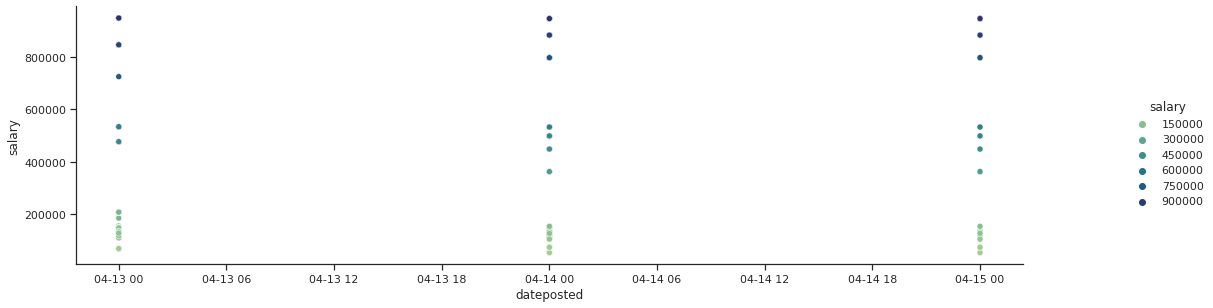

In [502]:
ax = sns.pairplot(data=munged[munged.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

A plot is helpful in isualizing data, but let's program a few functions to detect and remove outliers based on thresholds.
With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

#### Z-Score
Salaries 3 standard deviations away from the mean will be listed as outliers.

In [503]:
outliers = []
def z_detect(munged):
    sample = munged[munged['salary'].notnull()].salary
    threshold=3
    mean = np.mean(sample)
    std = np.std(sample)
    
    for i in sample:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
z_detect(munged)

#### IQR
Salaries outside 1.5 times the interquartile range boundaries, either above or below will be listed as outliers.

In [504]:
def iqr_detect(munged):
    sample = munged[munged['salary'].notnull()].salary
    Q1, Q3 = np.percentile(sample,[25,75])
    iqr = Q3-Q1
    lower_bound = Q1-(1.5*iqr)
    upper_bound = Q3+(1.5*iqr)
    for i in sample:
        if (i < lower_bound)  | (i > upper_bound):
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
iqr_detect(munged)

[947120.0,
 845107.0,
 947120.0,
 845107.0,
 723915.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 533000.0,
 476000.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 947120.0,
 845107.0,
 533000.0,
 476000.0,
 533000.0,
 476000.0,
 947120.0,
 845107.0,
 533000.0,
 476000.0,
 947120.0,
 845107.0,
 533000.0,
 476000.0,
 947120.0,
 845107.0,
 945120.0,
 796101.0,
 882112.0,
 532000.0,
 498000.0,
 448000.0,
 498000.0,
 497000.0,
 945120.0,
 882112.0,
 796101.0,
 945120.0,
 796101.0,
 882112.0,
 532000.0,
 498000.0,
 498000.0,
 448000.0,
 497000.0,
 532000.0,
 498000.0,
 796101.0,
 882112.0,
 945120.0,
 796101.0,
 882112.0,
 532000.0,
 448000.0,
 497000.0,
 498000.0,
 498000.0,
 945120.0,
 796101.0,
 882112.0,
 532000.0,
 498000.0,
 448000.0,
 498000.0,
 497000.0,
 945120.0,
 882112.0,
 796101.0,
 945120.0,
 796101.0,
 882112.0,
 532000.0,

In [505]:
def unique(list1):
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    for x in unique_list:
        print(x)
        
mn = min(outliers)
mx = max(outliers)
print(f'The {len(set(outliers))} Unique Outliers Are:')
unique(outliers)
print(f'- With a minumum of ${round(mn)} and a maximum of ${round(mx)}')

The 12 Unique Outliers Are:
476000.0
945120.0
882112.0
532000.0
448000.0
796101.0
533000.0
497000.0
723915.0
947120.0
498000.0
845107.0
- With a minumum of $448000 and a maximum of $947120


In [507]:
# Take a look at those tables.

outliers = munged[munged['salary'].isin(outliers)]
munged.drop(outliers.index, axis=0,inplace=True)
outliers

,company,location,rating,job_title,text,salary,dateposted,state,city
3,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
7,eab,"remote in washington, dc 20036",3.7,associate data scientist,"#li-remote about eab at eab, our mission is to...",845107.0,2022-04-13,dc,remote in washington
18,"emergetech, inc",remote,0.0,data scientist,description:job categorydata scienceabout emer...,947120.0,2022-04-13,remote,remote
22,eab,"remote in washington, dc 20036",3.7,associate data scientist,"#li-remote about eab at eab, our mission is to...",845107.0,2022-04-13,dc,remote in washington
33,the american college of radiology,+1 locationremote,4.2,clinical trials statistician (remote),the american college of radiology is a profess...,723915.0,2022-04-13,+1 locationremote,+1 locationremote
...,...,...,...,...,...,...,...,...,...
557,"vital connect, inc.",remote,0.0,data scientist,data scientistvitalconnect is a leader in wear...,532000.0,2022-04-15,remote,remote
560,multiplan inc.,remote,3.5,sr business data analyst,imagine a workplace that encourages you to int...,448000.0,2022-04-15,remote,remote
562,aledade,"remote in bethesda, md",3.5,data analyst / senior data analyst – impact an...,we are seeking new members of our impact an...,497000.0,2022-04-15,md,remote in bethesda
564,california fair plan association,"remote in los angeles, ca 90010",0.0,statistical reporting analyst (remote),position summary the statistical reporting ana...,498000.0,2022-04-15,ca,remote in los angeles


In [509]:
null = len(munged[munged.salary.isnull()])
nnull = len(munged[munged.salary.notnull()])

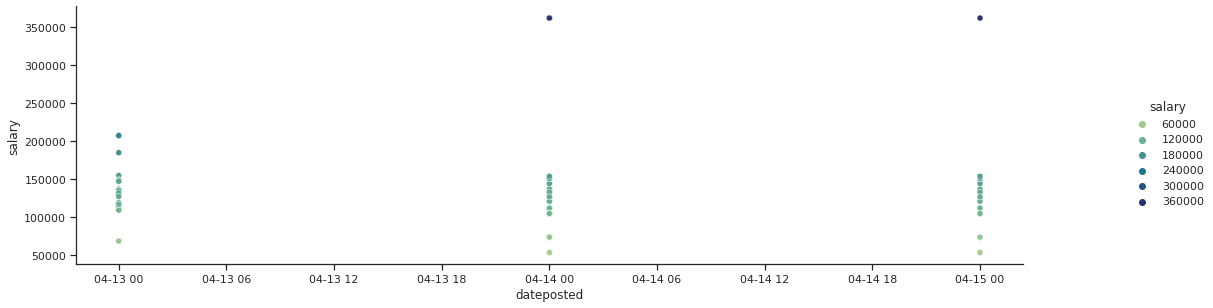

In [515]:
ax = sns.pairplot(data=munged[munged.salary.notnull()],
                  x_vars=['dateposted'],
                  y_vars=['salary'], height=8, hue="salary", palette="crest")

ax.fig.set_size_inches(18,4)

- Dropping 107 outliers now leaves 345, or 74.51%, of rows with with salary information,
- The remaining 118 rows, or 25.49%, are missing salary data.


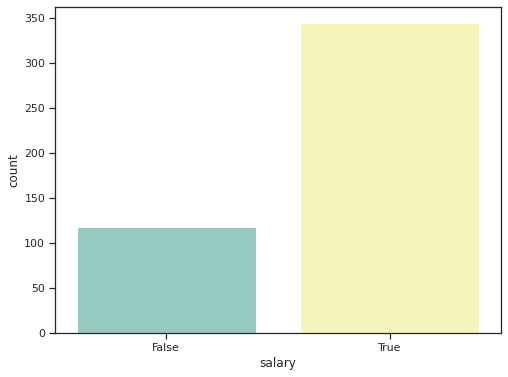

In [517]:
sns.countplot(x='salary', data=munged.notnull(), palette='Set3')
print(f'- Dropping {len(outliers)} outliers now leaves {nnull}, or {round(nnull/len(munged)*100,2)}%, of rows with with salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}%, are missing salary data.')


In [518]:
munged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463 entries, 0 to 569
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   company     463 non-null    object        
 1   location    463 non-null    object        
 2   rating      463 non-null    float64       
 3   job_title   463 non-null    object        
 4   text        463 non-null    object        
 5   salary      345 non-null    float64       
 6   dateposted  463 non-null    datetime64[ns]
 7   state       463 non-null    object        
 8   city        463 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 56.2+ KB


In [519]:
munged.to_csv(f'../app/data/munged_data.csv', index=False)